# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [235]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [236]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [237]:
print("Total Data :",len(df))

Total Data : 541909


In [238]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [239]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [240]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [241]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [242]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [243]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [245]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

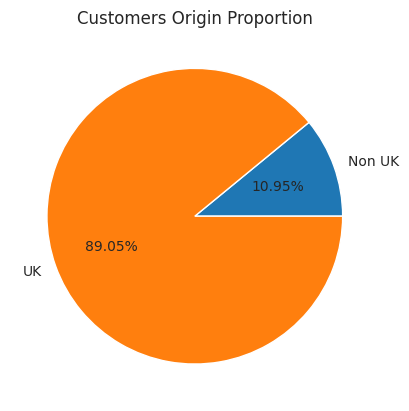

In [246]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [247]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [248]:
import matplotlib.dates as mdates
import plotly.graph_objects as go

In [249]:
# Convert 'InvoiceDate' column to datetime type if needed
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by weekly and calculate the sum of 'TotalAmount'
weekly_purchasements = df.groupby(pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

# Create the line plot using Plotly
fig = go.Figure(data=go.Scatter(x=weekly_purchasements.index, y=weekly_purchasements, mode='markers+lines'))

# Update the layout with title and axis labels
fig.update_layout(title='Weekly Purchasement Trend', yaxis_title='Total Amount')

# Show the plot
fig.show()

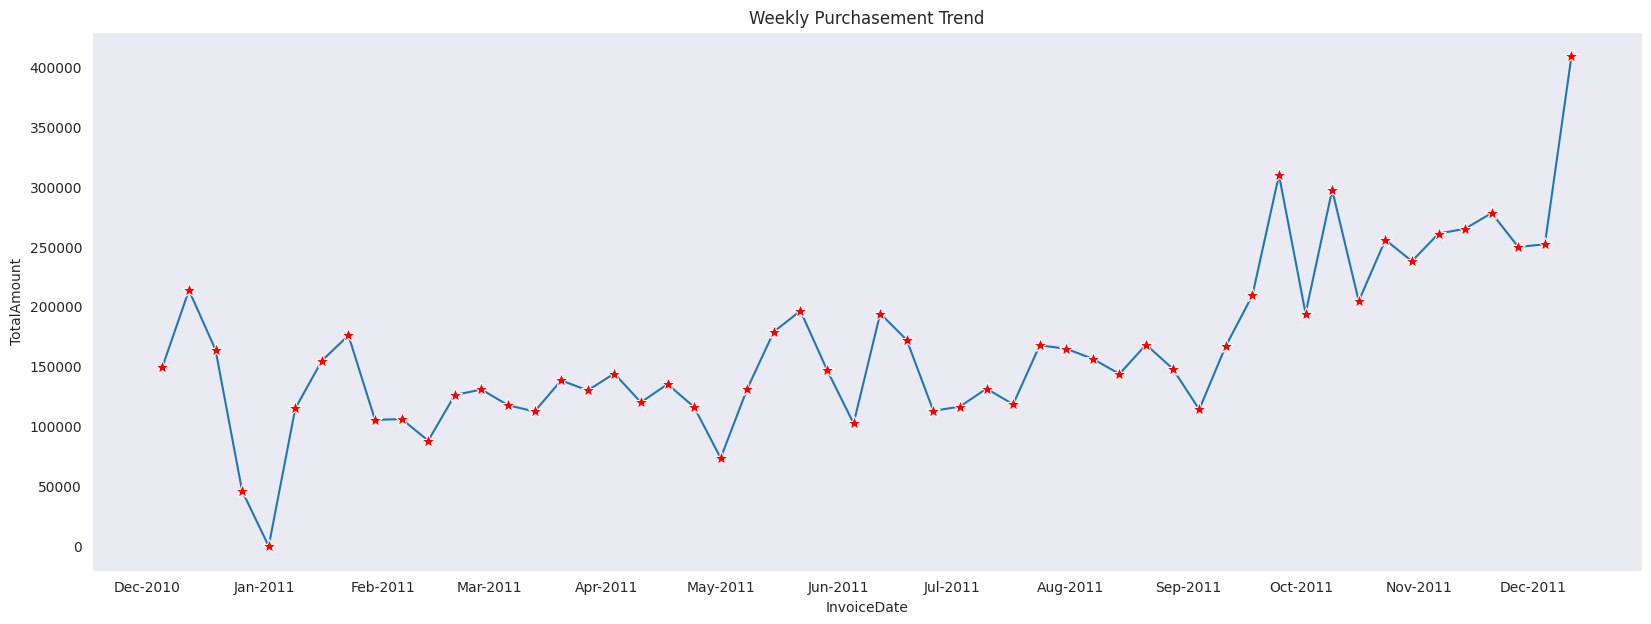

In [250]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

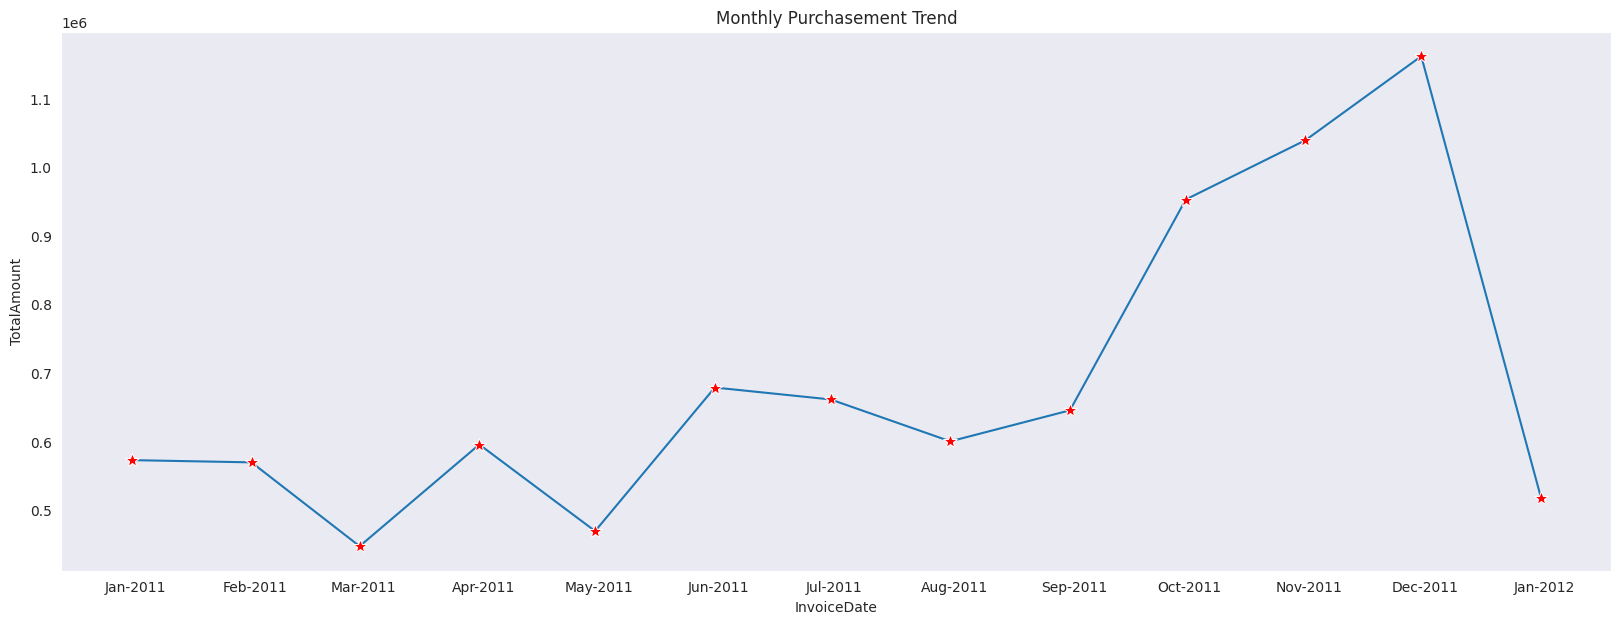

In [251]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(
    by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [252]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max() # melihat max (terupdate) si pelanggan melakukan pembelanjaan.
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

**Analisa**

1. Melihat recency terakhir dari semua user.
2. recenci itu adalah waktu ter-update si pembeli melakukan transaksi.
3. customerId : 12346 (paling lama tidak melakukan transaksi)

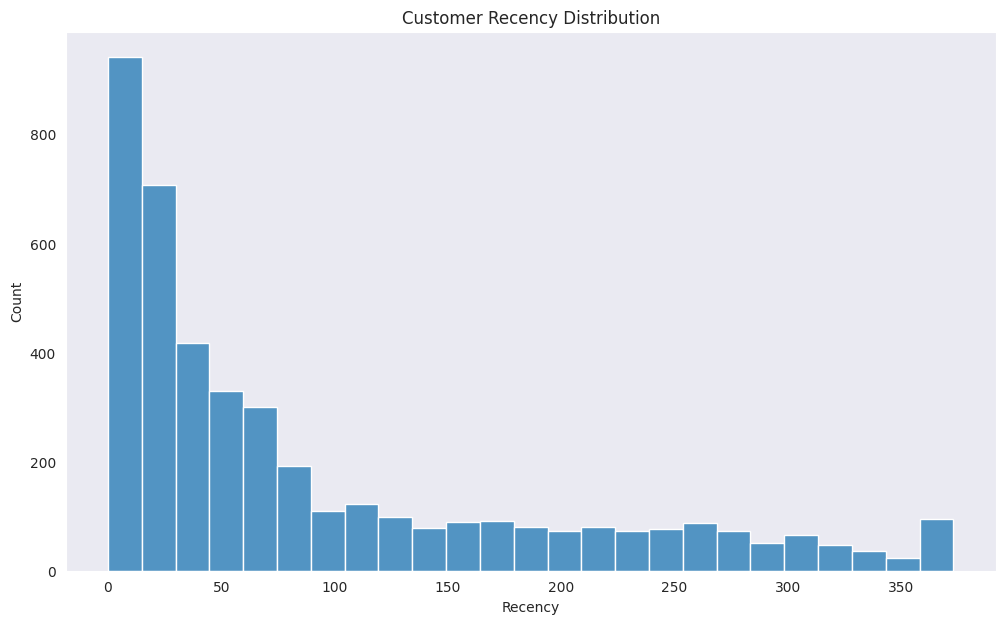

In [253]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [254]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()

#frequency = frequency.sort_values(ascending=False)
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

**ANALISA**

1. 12346 hanya membeli 1 kali pembelian

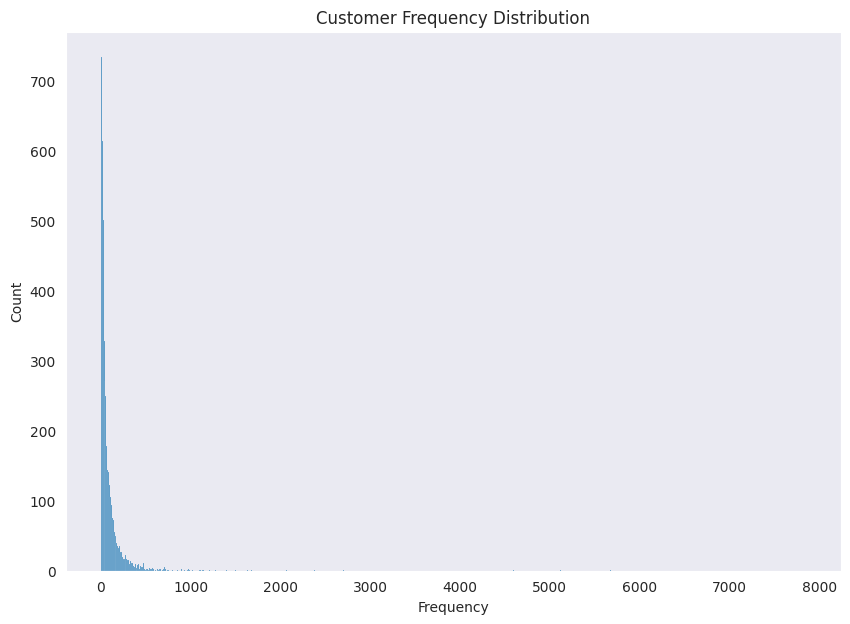

In [255]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [256]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()

monetary = monetary.sort_values(ascending=False)
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
Name: Monetary, dtype: float64

**ANALISA**

1. CutomerID : 14646 - melakukan transasi dengan pembelian terbesar

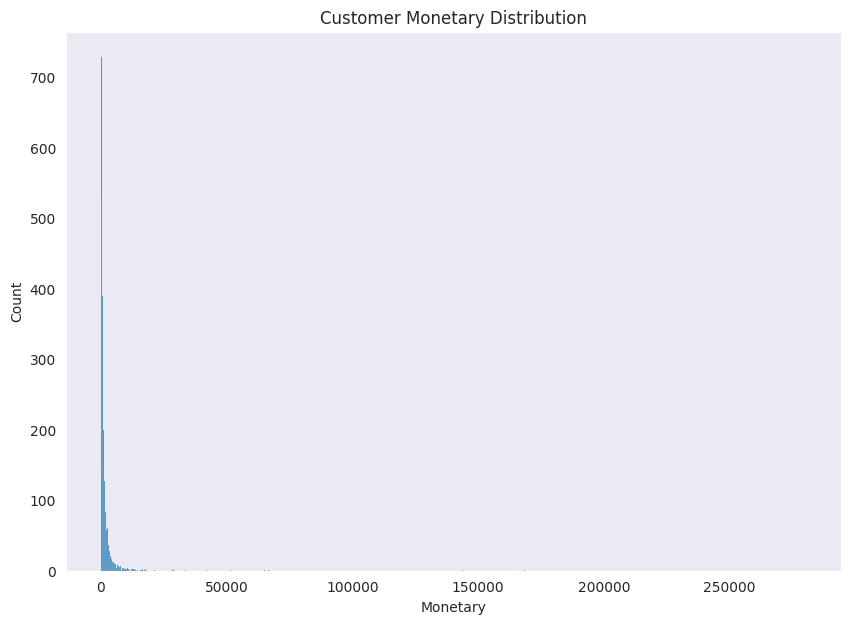

In [257]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [258]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)

# Merge the data
df_new = (
    country
    .merge(recency, on='CustomerID')
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [259]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

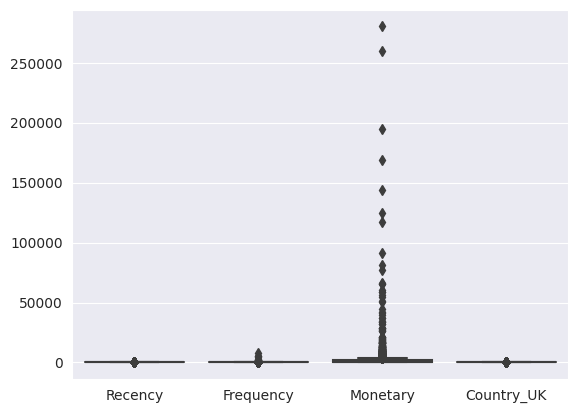

In [260]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [261]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


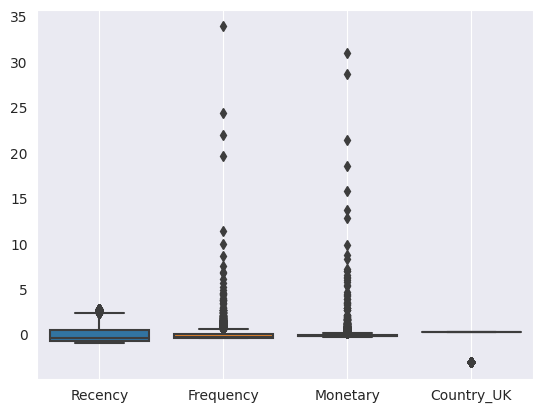

In [262]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [263]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [264]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

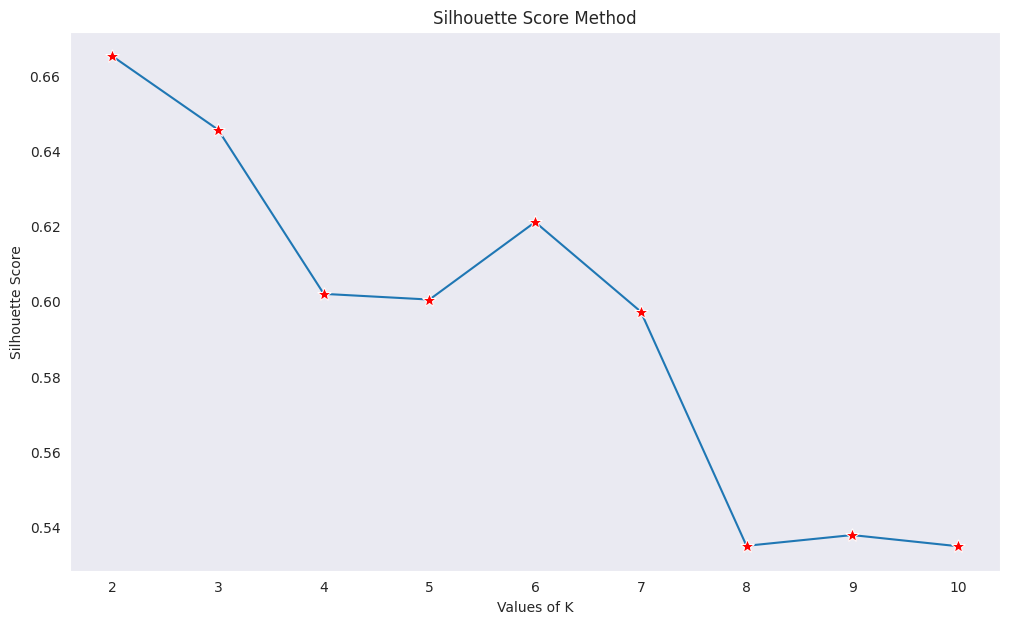

In [265]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

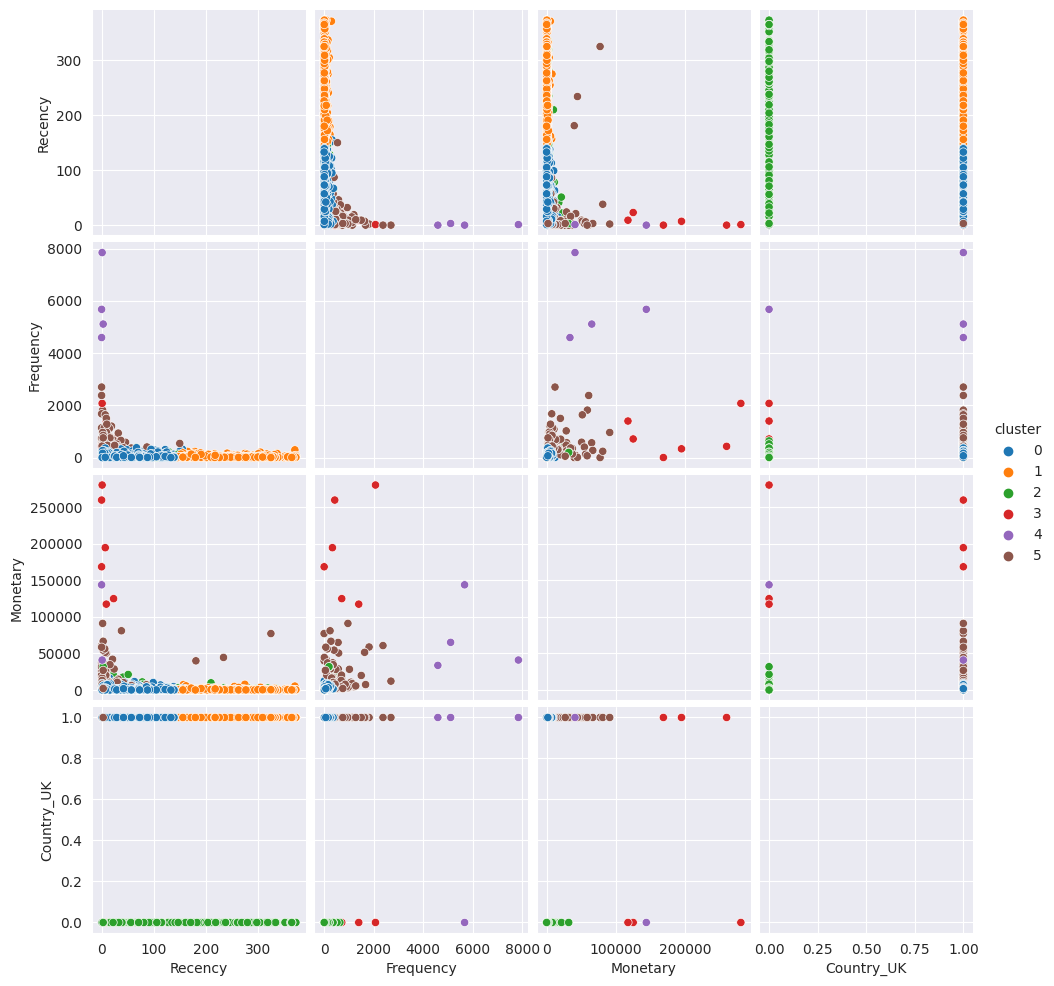

In [266]:
kmeans = KMeans(
    n_clusters=6,
    random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [267]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0            1             2              3  \
Recency   mean       42.676884   246.776618     95.405797       6.666667   
          std        36.313016    65.636727    104.638705       8.869423   
          min         0.000000   143.000000      0.000000       0.000000   
          q25        14.000000   189.000000     18.000000       0.250000   
          median     31.000000   242.000000     52.000000       4.000000   
          q75        64.000000   296.000000    136.500000       8.500000   
          max       155.000000   373.000000    373.000000      23.000000   
Frequency mean       76.270826    27.689979     81.396135     826.833333   
          std        74.030983    32.176026     96.304061     771.620481   
          min         1.000000     1.000000      1.000000       3.000000   
          q25        22.000000     8.250000     21.250000     360.500000   
          median     51.000000    18.000000     45.000000     572.500000   
          q75       107.000000    33.000000    101.000000    1228.500000   
          max       385.000000   297.000000    638.000000    2076.000000   
Monetary  mean     1341.293935   450.793070   2262.538913  190863.461667   
          std      1592.871914   610.367153   3479.689136   67791.993010   
          min         6.200000     3.750000     51.560000  117379.630000   
          q25       371.700000   163.225000    459.650000  135804.022500   
          median    795.120000   305.515000   1025.700000  181511.645000   
          q75      1720.300000   505.542500   2659.962500  243380.672500   
          max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                       4             5  
Recency   mean         1.000000     15.234973  
          std          1.414214     35.305176  
          min          0.000000      0.000000  
          q25          0.000000      2.000000  
          median       0.500000      6.000000  
          q75          1.500000     16.000000  
          max          3.000000    325.000000  
Frequency mean      5807.000000    535.360656  
          std       1429.730044    358.078267  
          min       4595.000000      1.000000  
          q25       4982.000000    367.000000  
          median    5393.000000    450.000000  
          q75       6218.000000    589.500000  
          max       7847.000000   2700.000000  
Monetary  mean     70925.287500  13085.065738  
          std      50424.336433  16313.461152  
          min      33719.730000   1093.650000  
          q25      39173.610000   4014.945000  
          median   53078.180000   6923.130000  
          q75      84829.857500  13213.210000  
          max     143825.060000  91062.380000

In [268]:
df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


**ANALISA**

1. Cluster dari kelas 3&4 cukup baik dilihat dari RFM-nya.
2. cluster 1 yang paling buruk dari RFM-nya.

In [269]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

In [295]:
# Memfilter data di mana kolom 'Country_UK' memiliki nilai '1'
df_uk_filtered = df_result_kmeans[df_result_kmeans['Country_UK'] == 1]

# Menampilkan hasil filtrasi
print(df_uk_filtered.head())

            Recency  Frequency  Monetary  Country_UK  cluster
CustomerID                                                   
12346.0         325          1  77183.60           1        5
12747.0           1        103   4196.01           1        0
12748.0           0       4595  33719.73           1        4
12749.0           3        199   4090.88           1        0
12820.0           2         59    942.34           1        0


In [297]:
# Memfilter data di mana kolom 'Country_UK' memiliki nilai '1'
df_non_uk_filtered = df_result_kmeans[df_result_kmeans['Country_UK'] == 0]

# Menampilkan hasil filtrasi
print(df_non_uk_filtered.head())

            Recency  Frequency  Monetary  Country_UK  cluster
CustomerID                                                   
12347.0           1        182   4310.00           0        2
12348.0          74         31   1797.24           0        2
12349.0          18         73   1757.55           0        2
12350.0         309         17    334.40           0        2
12352.0          35         85   2506.04           0        2


# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a)Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.

In [270]:
#Top 5 Customer
# Frequency
# Urutkan frekuensi secara menurun (descending)
sorted_frequency = frequency.sort_values(ascending=False)

# Ambil 5 pelanggan teratas dengan frekuensi transaksi terbanyak
top_5_cust = sorted_frequency.head(5)

# Tampilkan hasilnya
print(top_5_cust)

CustomerID
17841.0    7847
14911.0    5675
14096.0    5111
12748.0    4595
14606.0    2700
Name: Frequency, dtype: int64


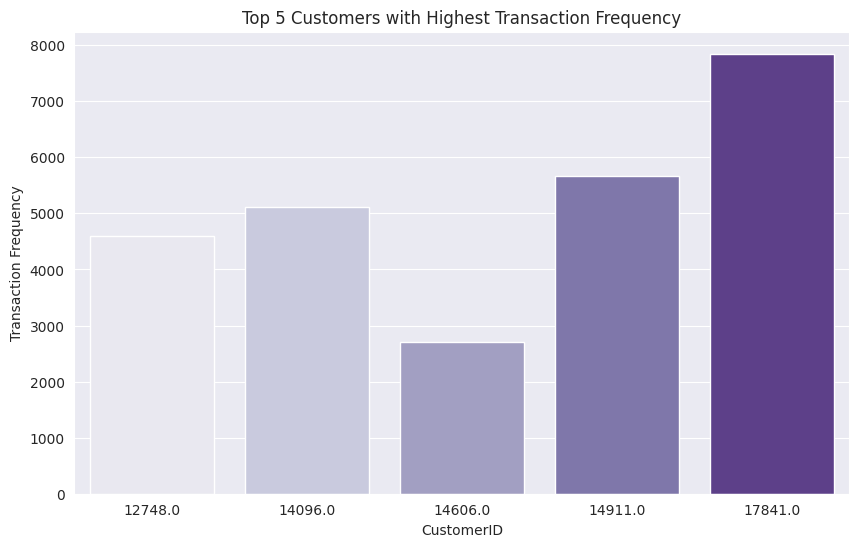

In [271]:
# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_cust.index, y=top_5_cust.values, palette='Purples')
plt.xlabel('CustomerID')
plt.ylabel('Transaction Frequency')
plt.title('Top 5 Customers with Highest Transaction Frequency')
plt.show()

In [272]:
#menampilkan frequncy pembelian terbanyak berdasarkan waktu.
#membuat feature baru

# Create new features and cast date column
frequency_date = df['InvoiceDate'].value_counts()

sorted_frequency = frequency_date.sort_values(ascending=False)
top_5_date =sorted_frequency.head(5)

print(top_5_date)

2011-11-14 15:27:00    542
2011-11-28 15:54:00    533
2011-12-05 17:17:00    529
2011-11-23 13:39:00    443
2011-10-31 14:09:00    435
Name: InvoiceDate, dtype: int64


In [273]:
# Ubah kolom 'InvoiceDate' menjadi tipe datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [274]:
# Calculate the number of transactions for each customer
transaction_frequency = df['CustomerID'].value_counts()

# Calculate the time since the last transaction for each customer
last_transaction_date = df.groupby('CustomerID')['InvoiceDate'].transform('max')
time_since_last_transaction = df['InvoiceDate'].max() - last_transaction_date

# Define criteria for "royal" and "loyal" customers
royal_threshold = 3  # Number of transactions to be considered "royal" (adjust as needed)
loyal_threshold = pd.Timedelta('30 days')  # Time difference to be considered "loyal" (adjust as needed)

# Identify "royal" customers (frequent transactions)
royal_customers = transaction_frequency[transaction_frequency >= royal_threshold]
sorted_royal_customer = royal_customers.sort_values(ascending=False)
top_5_royal_customer = sorted_royal_customer.head(5)


# Identify "loyal" customers (consistent transactions)
loyal_customers = time_since_last_transaction[time_since_last_transaction <= loyal_threshold]
sorted_loyal_customer = loyal_customers.sort_values(ascending=False)
top_5_loyal_customer = sorted_loyal_customer.head()

In [275]:
print("Royal Customers:")
print(top_5_royal_customer)


print("\nLoyal Customers:")
print(top_5_loyal_customer)

Royal Customers:
17841.0    7847
14911.0    5675
14096.0    5111
12748.0    4595
14606.0    2700
Name: CustomerID, dtype: int64

Loyal Customers:
199349   29 days 23:33:00
199351   29 days 23:33:00
199348   29 days 23:33:00
199347   29 days 23:33:00
452029   29 days 23:33:00
Name: InvoiceDate, dtype: timedelta64[ns]


2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?


**Cluster 0:**

recency : 42 hari
frequency pembelian : 76 kali
Uang yang di keluarkan 1341

*Karakter Cluster*
1. Cukup jarang belanja
2. Belanja sesuai kebutuhan dan tidak terlalu mahal.

*Promo yang disarankan*
1. Gratis ongkir dengan maksimal pembelian.
2. Voucher belanja yang terbatas.

**Cluster 1:**

recency: 246
Frequency pembelian: 27
Uang yang dkeluarkan: 450

*Karakter Cluster*
1. Cukup jarang belanja.
2. Hanya kustomer yang belanja musiman atau even tertentu.

*Promo yang disarankan*
1. Gratis ongkir dengan maksimal pembelian.
2. Voucher belanja yang terbatas.

**Cluster 2:**
recency: 95
Frequency pembelian: 81
Uang yang dkeluarkan: 2262

*Karakter Cluster*
1. Sangat atau hampir tidak pernah belanja.
2. Hanya kustomer yang belanja musiman atau even tertentu.

*Promo yang disarankan*
1. Gratis ongkir dengan maksimal pembelian.
2. Voucher belanja yang terbatas.

**Cluster 3:**
recency: 6
Frequency pembelian: 826
Uang yang dkeluarkan: 190.863

*Karakter dari cluster*:
1. Transaksi tidak banyak, namun uang yang di habiskan tinggi.
2. Biasanya cluster ini dimiliki oleh orang yang suka belanja barang mahal.
3. Royal Customer

*Promo yang disarankan*
1. Gratis ongkir.
2. Voucher belanja.
3. Notification berupa potongan harga dari beberapa brand yang sering dilirik atau di cari oleh pembeli.

**Cluster 4:**
recency: 1
Frequency pembelian: 5807
Uang yang dkeluarkan: 70925

*Karakter Cluster*
1. Hampir sama dengan karakter dari cluster 3.
2. Sangat rajin untuk belanja.
3. Kemungkinan hanya membeli banyak barang namun dengan harga yang tidak begitu mahal.
4. Loyal Customer

*Promo yang disarankan*
1. Gratis ongkir.
2. Voucher belanja atau potongan harga.

**Cluster 5:**
recency: 15
Frequency pembelian: 535
Uang yang dkeluarkan: 13085

*Karakter Cluster*
1. Cukup rajin untuk belanja.
3. Kemungkinan hanya membeli banyak barang namun dengan harga yang tidak begitu mahal.

*Promo yang disarankan*
1. Gratis ongkir dengan ketentuan
2. Voucher belanja atau potongan harga dengan ketentuan yang cukup ketat.


3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

In [298]:
# Menampilkan hasil filtrasi
print(df_non_uk_filtered.head())

            Recency  Frequency  Monetary  Country_UK  cluster
CustomerID                                                   
12347.0           1        182   4310.00           0        2
12348.0          74         31   1797.24           0        2
12349.0          18         73   1757.55           0        2
12350.0         309         17    334.40           0        2
12352.0          35         85   2506.04           0        2


In [304]:
# Analisis karakteristik kluster untuk pelanggan non-UK
cluster_characteristics_non_uk = df_non_uk_filtered.groupby('cluster')['Recency'].mean()
print(cluster_characteristics_non_uk)

cluster
2    95.405797
3    11.000000
4     0.000000
Name: Recency, dtype: float64


In [303]:
# Analisis karakteristik kluster untuk pelanggan non-UK
cluster_characteristics_non_uk = df_non_uk_filtered.groupby('cluster')['Frequency'].mean()
print(cluster_characteristics_non_uk)

cluster
2      81.396135
3    1396.666667
4    5675.000000
Name: Frequency, dtype: float64


In [301]:
# Analisis karakteristik kluster untuk pelanggan non-UK
cluster_characteristics_non_uk = df_non_uk_filtered.groupby('cluster')['Monetary'].mean()
print(cluster_characteristics_non_uk)

cluster
2      2262.538913
3    174166.726667
4    143825.060000
Name: Monetary, dtype: float64


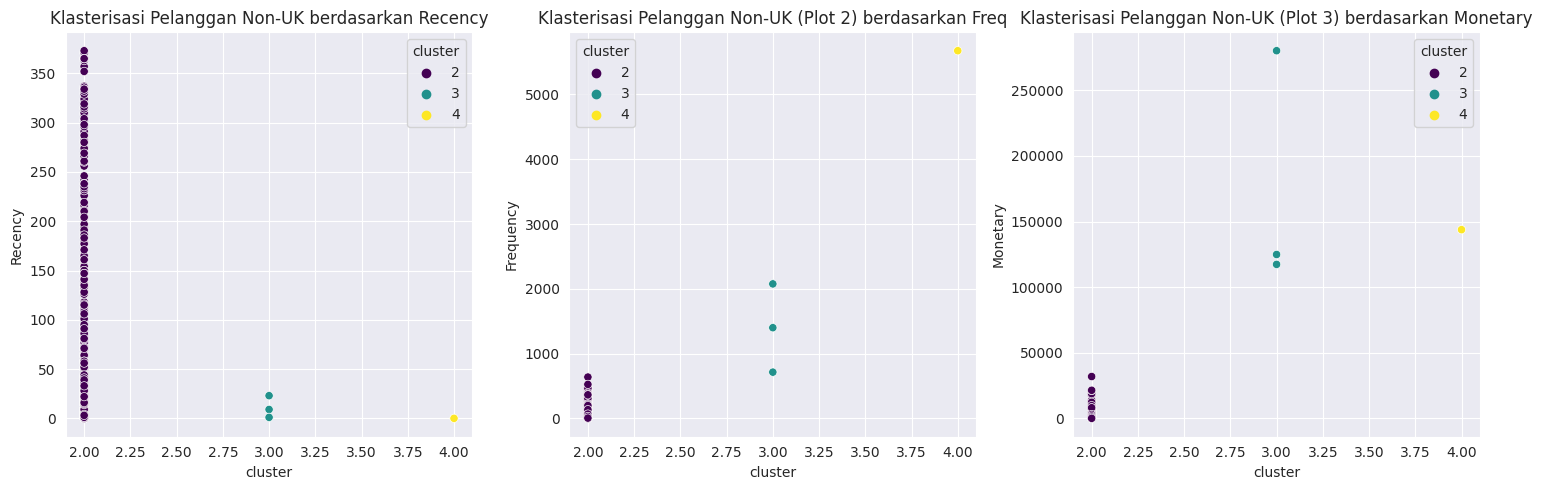

In [315]:
# Membuat subplot dengan 1 baris dan 3 kolom
plt.figure(figsize=(15, 5))

# Plot 1
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_non_uk_filtered, x='cluster', y='Recency', hue='cluster', palette='viridis')
plt.xlabel('cluster')
plt.ylabel('Recency')
plt.title('Klasterisasi Pelanggan Non-UK berdasarkan Recency')

# Plot 2
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_non_uk_filtered, x='cluster', y='Frequency', hue='cluster', palette='viridis')
plt.xlabel('cluster')
plt.ylabel('Frequency')
plt.title('Klasterisasi Pelanggan Non-UK (Plot 2) berdasarkan Freq')

# Plot 3
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_non_uk_filtered, x='cluster', y='Monetary', hue='cluster', palette='viridis')
plt.xlabel('cluster')
plt.ylabel('Monetary')
plt.title('Klasterisasi Pelanggan Non-UK (Plot 3) berdasarkan Monetary')

plt.tight_layout()
plt.show()

Dari visualisasi di atas dapat dilihat bahwa Buyer dari Non-UK berada pada cluster 2,3,4.

Dimana mayoritas berada di cluster 2.

Dari segi Recency, untuk Non-Uk merupakan buyer cukup recency melihat atau melakukan pembelian, sedikit melakukan transaksi namun dari segi monetari cukup besar walaupun tidak terlalu besar.